The year is 2080 AD, the inaugural season of the much anticipated ROBO-BATTER 5000 project from the University of Phoenix's Cybernetics Department. ROBO-BATTER has a famously mechanically perfect swing and uses advanced computer vision and telemetry to recognize and track all pitches and crush them for a homerun. Unfortunately there is a pre-swing mechanical warm up time engineering flaw, so ROBO-BATTER must decide prior to the pitch being thrown whether it will be a fastball or an offspeed pitch. If it guesses wrong, it somehow chops the ball right back to the pitcher for an easy groundout.

Therefore, the success of ROBO-BATTER depends entirely on how well it can predict what class of pitch is coming next -- a fastball or an offspeed pitch.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') #ain't got time for negativity in my life

In [40]:
#read in data from file
raw_pitch_df = pd.read_csv('pitches.csv')

In [41]:
#look at # of rows and columns
raw_pitch_df.shape

(718961, 125)

In [42]:
#look for data with all nulls
raw_pitch_df.isnull().sum()

uid                    0
game_pk                0
year                   0
date                   0
team_id_b              0
team_id_p              0
inning                 0
top                    0
at_bat_num             0
pcount_at_bat          0
pcount_pitcher         0
balls                  0
strikes                0
fouls                  0
outs                   0
is_final_pitch         0
final_balls            0
final_strikes          0
final_outs             0
start_tfs              0
start_tfs_zulu         0
batter_id              0
stand                  0
b_height               0
pitcher_id             0
p_throws               0
at_bat_des             0
event                  0
event2            710662
event3            718627
                   ...  
runner4_end       718961
runner4_event     718961
runner4_score     718961
runner4_rbi       718961
runner4_earned    718961
runner5_id        718961
runner5_start     718961
runner5_end       718961
runner5_event     718961


In [43]:
#drop all empty columns (all values are null or NaN)
raw_pitch_df.dropna(axis='columns', how='all', inplace=True)
raw_pitch_df.shape

(718961, 76)

In [44]:
#lets see what pitch types are in the data set
raw_pitch_df.pitch_type.value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64

In [45]:
#remove novelty pitches and non-standard pitch events like pitchouts
raw_pitch_df=raw_pitch_df[raw_pitch_df.pitch_type.isin(['FF','SL','SI','FT','CH','CU','FC','FS','KC','FA'])]

In [46]:
#remaining pitch types
raw_pitch_df.pitch_type.value_counts()

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
FA       204
Name: pitch_type, dtype: int64

In [47]:
#some feature creation/refinement
raw_pitch_df['is_fastball']=np.where(raw_pitch_df.pitch_type.isin(['FF','SI','SI','FT','FA','FS']), 1, 0)
raw_pitch_df['runner_on_1st']=np.where(~raw_pitch_df.on_1b.isnull(), 1, 0)
raw_pitch_df['runner_on_2nd']=np.where(~raw_pitch_df.on_2b.isnull(), 1, 0)
raw_pitch_df['runner_on_3rd']=np.where(~raw_pitch_df.on_3b.isnull(), 1, 0)
raw_pitch_df['total_baserunners']=raw_pitch_df['runner_on_1st'] + raw_pitch_df['runner_on_2nd'] + raw_pitch_df['runner_on_3rd']
raw_pitch_df['is_offspeed']=1-raw_pitch_df['is_fastball']

In [64]:
raw_pitch_df.is_fastball.value_counts(normalize=True)

1    0.591283
0    0.408717
Name: is_fastball, dtype: float64

In [49]:
#create test and train datasets, 80/20 split
test_df, train_df = train_test_split(raw_pitch_df, test_size=0.2)

In [50]:
test_df.shape

(565609, 82)

Intelligently selecting features is the most important aspect of building a model like this. There are two primary goals when choosing features -- one is to find highly discriminatory features -- meaning features that do a good job of separating the response variable. The other is avoiding overfit, which can cause model performance to be artificially high. An example of an overfitting feature in this example would be break_length. This data is not known until after the pitch is thrown, so its sort of like giving the model the answer key before the test. break_length would be highly discriminatory since it would be a strong indicator of curveballs and sliders, which are offspeed, but not valuable in building a predictive model because it is not known at the time we need the predictions for the appropriate swing response.

Therefore, we are trying to find *quantitative* data that is known and only known *before the pitch is thrown* -- essentially contextual information about the game. Balls, strikes, outs. Baserunners and things like that.

Ideally we'd have pitcher and batter tendancies as well, but that is a large feature collection project.

In [69]:
#selecting features for training

features = ['inning',
            'top',
            'at_bat_num',
            'pcount_at_bat',
            'pcount_pitcher',
            'balls',
            'strikes',
            'fouls',
            'outs',
            'runner_on_1st',
            'runner_on_2nd',
            'runner_on_3rd',
            'total_baserunners']

response = 'is_fastball'

In [70]:
#create and train random forest
runForrest=RandomForestClassifier(n_estimators=200, n_jobs=1, max_depth=10, max_features=10,
                                    min_samples_leaf=10, min_samples_split=20)
                                  
runForrest.fit(train_df[features], train_df[response])

probas=runForrest.predict_proba(test_df[features])
preds=runForrest.predict(test_df[features])

In [71]:
#some model performance metrics
print('AUC: ' + str(metrics.roc_auc_score(y_score=probas[:,1], y_true=test_df[response])))

print('logloss: ' + str(metrics.log_loss(y_pred=probas[:,1], y_true=test_df[response])))

print('accuracy score: ' + str(metrics.accuracy_score(test_df[response], preds)))

print('null accuracy: ' + str(max(test_df[response].mean(), 1 - test_df[response].mean())))

print(metrics.confusion_matrix(test_df[response], preds))

AUC: 0.629809387844
logloss: 0.646872085667
accuracy score: 0.602930646436
null accuracy: 0.591203463877
[[ 70878 160341]
 [ 64245 270145]]


AUC of .63 means we're making some good but not great predictions. Actually a bit better than expected given the small number of features. However, it is performing only slightly better than the null hypothesis of guessing fastball every single pitch.

Confusion matrix included to show the counts of True Positives, True Negatives, False Positives and False Negatives

In [72]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(test_df[response], preds)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


print((TP + TN) / float(TP + TN + FP + FN)) #Accuracy
print(TP / float(TP + FN)) #Sensitivity
print(TN / float(TN + FP)) #Specificity
print(FP / float(TN + FP)) #FPR
print(TP / float(TP + FP)) #Precision

0.602930646436
0.807874039295
0.306540552463
0.693459447537
0.627534925642


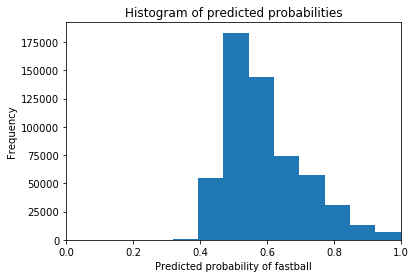

In [75]:
# histogram of predicted probabilities
plt.hist(probas[:,1], bins=10)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of fastball')
plt.ylabel('Frequency')

Histogram of the predicted fastball probabilities show that the model is not very confident when making preds. There are some circumstances where it is very confident a fastball is coming (like 3-0 counts). Other than those highly predictable circumstances, most probablities are between 40%-70% fastball.

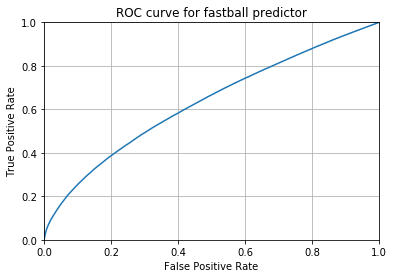

In [74]:
fpr, tpr, thresholds = metrics.roc_curve(test_df[response], probas[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for fastball predictor')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

ROC curve shows that there is not a lot of certainty between the probabilities of the 2 pitch classifications, meaning this model still needs quite a bit of work. As mentioned before, the best thing to do would be gather more features, which is usually the most labor intensive part of analysis. Beyond that, there might be some small incremental gains in performance if we did some hyperparameter tuning or a grid search -- but generally your predictions will only be as good as your data and features.

In the end, ROBO-BATTER still had a great rookie season. He set all kinds of records, like seeing only 1 pitch per plate appearance and becoming the leagues first and only 'Two True Outcome' hitter. Teammate Bartolo Colon described him as "Adam Dunn, except way funnier". With a correct response rate of 60.3%, he was able to turn his 650 plate appearances into 392 HR and 258 groundouts, good for a slash line of .603/.603/2.412, finishing 3rd in MVP voting behind the genetically modified reanimated corpse of Barry Bonds and Mike Trout.